## Reading in Historic Wildfire Data

### Author: Ryan Gan
### Date Created: 2018-06-30

Reading in fire shapefile.

In [42]:
# import geopandas, looks like it's similar to simple featurs
import geopandas as gp # geopandas brings in shapefiles as dataframe with spatial information
import pandas as pd # pandas dataframe

#import raster for tif
import rasterio
import rasterio.plot as rioplot

# offset month
from pandas.tseries.offsets import MonthBegin

import numpy as np # numpy to create new array
# interpolate griddate
from scipy import interpolate
# plots
# set figure size
from matplotlib import pyplot as plt 
%matplotlib inline
# plot size
plt.rcParams['figure.figsize'] = (10,8)
#import mpl_toolkits # i'd like basemap but doesn't seem to be available for py3
# Seaborn for plotting and styling
import seaborn as sns

Read in 1980 to 2016 wildfire data.

In [2]:
fires = gp.read_file('../data/shapes/wf_usfs_1980_2016/wf_usfs_1980_2016.shp')

View head of fires geopandas dataframe.

In [3]:
fires.head()

,ORGANIZATI,UNIT,SUBUNIT,SUBUNIT2,FIREID,FIRENAME,FIRENUMBER,FIRECODE,CAUSE,SPECCAUSE,...,DLONGITUDE,TOTALACRES,TRPGENCAUS,TRPSPECCAU,Cat_Field,DuplicateF,FireName_A,Keep,Duplicate_,geometry
0,FS,06,0616,Wallowa-Whitman National Forest,6752594,Elk Creek,056,EK2N,Human,9,...,-117.934167,0.3,8,9,EK2N/2016/Oregon/ELK CREEK,EK2N,ELK CREEK,None,0,POINT (-117.9341666698559 44.74138889038505)
1,FS,06,0602,Fremont-Winema National Forest,6770108,Indian,028,KMG9,Human,9,...,-122.190000,0.1,8,9,KMG9/2016/Oregon/INDIAN,None,INDIAN,None,0,POINT (-122.1899999996003 42.39722221982964)
2,FS,08,0809,Ouachita National Forest,6757702,Sweetwater,067,KHE1,Natural,1,...,-93.436111,315.0,0,1,KHE1/2016/Arkansas/SWEETWATER,None,SWEETWATER,None,0,POINT (-93.4361111097399 34.75694443973418)
3,FS,03,0307,Kaibab National Forest,6768482,STINA,042,EKV6,Natural,1,...,-112.333056,0.5,0,1,EKV6/2016/Arizona/STINA,EKV6,STINA,None,0,POINT (-112.3330555596663 36.37361110976497)
4,FS,01,0118,Dakota Prairie Grasslands,6775526,5A,015,EKT6,Natural,1,...,-102.401667,2.5,0,1,EKT6/2016/South Dakota/5A,EKT6,5A,None,0,POINT (-102.4016666697809 45.82166667028065)


In [4]:
# view variable names
fires.dtypes

ORGANIZATI     object
UNIT           object
SUBUNIT        object
SUBUNIT2       object
FIREID         object
FIRENAME       object
FIRENUMBER     object
FIRECODE       object
CAUSE          object
SPECCAUSE       int64
STATCAUSE       int64
SIZECLASS      object
SIZECLASSN    float64
FIRETYPE       object
PROTECTION     object
FIREPROTTY     object
YEAR_          object
FiscalYear      int64
STARTDATED     object
CONTRDATED     object
OUTDATED       object
GACC           object
DISPATCH       object
STATE          object
STATE_FIPS     object
FIPS          float64
DLATITUDE     float64
DLONGITUDE    float64
TOTALACRES    float64
TRPGENCAUS      int64
TRPSPECCAU      int64
Cat_Field      object
DuplicateF     object
FireName_A     object
Keep           object
Duplicate_      int64
geometry       object
dtype: object

In [5]:
# view first 5 dates
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']][:5]

,STARTDATED,CONTRDATED,OUTDATED
0,2016-10-02,2016-10-04,2016-10-14
1,2016-08-17,2016-08-17,2016-08-17
2,2016-07-22,2016-08-16,2016-09-02
3,2016-07-19,2016-07-21,2016-07-25
4,2016-07-14,2016-07-22,2016-07-22


Convert dates to datetime.

In [6]:
# convert date variables to date time
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']] = (fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']]
                                                      .apply(pd.to_datetime, errors = 'coerce'))

In [7]:
# check to make sure it's now a date time
fires[['STARTDATED', 'CONTRDATED', 'OUTDATED']].dtypes

STARTDATED    datetime64[ns]
CONTRDATED    datetime64[ns]
OUTDATED      datetime64[ns]
dtype: object

### Assigning Grid ID to Fire ID

I want to extract the latitude and longitude of each fire and find what grid ID it's closest to and assign it that grid ID. This will allow me to join climate predictor features to the fire event.

In [8]:
# latitude and longitude values and fire ids
f_lat = fires['DLATITUDE'].values
f_lon = fires['DLONGITUDE'].values
fire_ids = fires['FIREID'].values

In [9]:
# print first ids of lats lons and fires
print(f_lat[:5])
print(f_lon[:5])
print(fire_ids)

[44.74138889 42.39722222 34.75694444 36.37361111 45.82166667]
[-117.93416667 -122.19        -93.43611111 -112.33305556 -102.40166667]
['6752594' '6770108' '6757702' ... '385060' '310380' '1452438']


Make the same custom grid as my regrided climate data to assign values to.

In [10]:
# custom grids for every degree
# vectors
grid_lat = np.arange(24, 50.0, 1)
grid_lon = np.arange(-125.0, -66, 1)
# mesh grid arrayw
glons, glats = np.meshgrid(grid_lon, grid_lat)

Plot points to make sure grid looks right.

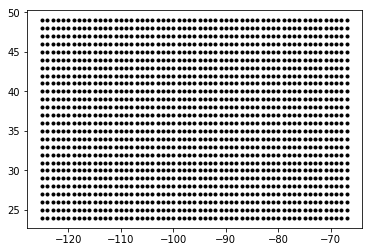

In [11]:
# plot new grid
plt.plot(glons, glats, marker='.', color='k', linestyle='none')
plt.show()

In [12]:
# shape of grid
print(np.shape(glons), np.shape(glats))

(26, 59) (26, 59)


Use the new glons and glats coordinates to generate a sequential number of grid IDs.

In [13]:
# grid id array; using reshape of sequential vector of ids, and giving shape of glons
grid_id = np.arange(1, 1535,1)
grid_id_array = np.reshape(grid_id, np.shape(glats))

In [14]:
np.shape(grid_id_array)

(26, 59)

In [15]:
# now I want to assign the grid ID based on the cell/point.
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T
# check dimensions
np.shape(us_grid)

(1534, 2)

Interpolate grid ID to fire coordinates based on nearest neighbor of grid id value.

In [16]:
# set up interpolate to nearest neighbor fuction
near_interp = interpolate.NearestNDInterpolator(us_grid, grid_id)

In [17]:
# apply near_interp to each fire id coordinate
fire_grid_id = near_interp(f_lon, f_lat)

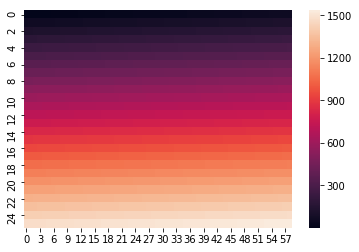

In [18]:
# plotting grid id value array
sns.heatmap(grid_id_array)

In [19]:
# check first couple ids
fire_grid_id[:10]

array([1247, 1066,  682,  722, 1322,  833,  628,  629,  629,  629])

In [20]:
# create dataframe with coordinates, fireid, and gridid
fire_grid = np.concatenate((fire_ids, f_lon, f_lat), axis=0)

In [21]:
# check to make sure fire grid id and fire ids are same dimension
np.shape(fire_grid_id) == np.shape(fire_ids)

True

Create a dataframe of keys that links the grid id to the FIRE ID so I can know the grid the fire took place in.

In [22]:
fire_grid = pd.DataFrame(data = {'lat' : f_lat, 'lon' : f_lon,
                                 'FIREID' : fire_ids, 'grid_id' : fire_grid_id})

In [23]:
# view first couple ids
fire_grid.head()

,lat,lon,FIREID,grid_id
0,44.741389,-117.934167,6752594,1247
1,42.397222,-122.190000,6770108,1066
2,34.756944,-93.436111,6757702,682
3,36.373611,-112.333056,6768482,722
4,45.821667,-102.401667,6775526,1322


In [24]:
# join grid_id back in to fire geopandas dataframe; inner joining to exclude fires outside my grid like Alaska
fires_w_grid = fires.merge(fire_grid, left_on = 'FIREID', right_on = 'FIREID', how = 'left')

In [25]:
# set grid_id to character and remove duplicates
fires_w_grid['grid_id'] = fires_w_grid['grid_id'].astype(str)
# remove duplicates
fires_w_grid = fires_w_grid[(fires_w_grid['Duplicate_'] == 0) & 
                            (fires_w_grid['STATE'] != 'Alaska')]
# add year-month 
fires_w_grid['date'] = fires_w_grid['STARTDATED'] + MonthBegin(-1) # needs -1 to set back month

In [26]:
# make sure date is the start of the month
print(fires_w_grid['date'][:5])
print(fires_w_grid['STARTDATED'][:5])
#x.dt.floor(freq = 'MS')

0   2016-10-01
1   2016-08-01
2   2016-07-01
3   2016-07-01
4   2016-07-01
Name: date, dtype: datetime64[ns]
0   2016-10-02
1   2016-08-17
2   2016-07-22
3   2016-07-19
4   2016-07-14
Name: STARTDATED, dtype: datetime64[ns]


In [27]:
fires_w_grid['STATE'].unique()  

array(['Oregon', 'Arkansas', 'Arizona', 'South Dakota', 'California',
       'Alabama', 'Colorado', 'Virginia', 'Georgia', 'Tennessee',
       'Kentucky', 'Ohio', 'Texas', 'Idaho', 'North Carolina', 'Utah',
       'Illinois', 'Wyoming', 'Minnesota', 'Montana', 'New Mexico',
       'South Carolina', 'Florida', 'Missouri', 'Nevada', 'Washington',
       'Vermont', 'Louisiana', 'Nebraska', 'New Hampshire',
       'Pennsylvania', 'Michigan', 'Oklahoma', 'Wisconsin', 'Kansas',
       'New York', 'North Dakota', 'West Virginia', 'Mississippi',
       'Indiana', 'Maine'], dtype=object)

In [28]:
fires_w_grid.shape

(298225, 41)

In [29]:
# shape of fires with grid
fires_w_grid.head()

,ORGANIZATI,UNIT,SUBUNIT,SUBUNIT2,FIREID,FIRENAME,FIRENUMBER,FIRECODE,CAUSE,SPECCAUSE,...,Cat_Field,DuplicateF,FireName_A,Keep,Duplicate_,geometry,lat,lon,grid_id,date
0,FS,06,0616,Wallowa-Whitman National Forest,6752594,Elk Creek,056,EK2N,Human,9,...,EK2N/2016/Oregon/ELK CREEK,EK2N,ELK CREEK,None,0,POINT (-117.9341666698559 44.74138889038505),44.741389,-117.934167,1247,2016-10-01
1,FS,06,0602,Fremont-Winema National Forest,6770108,Indian,028,KMG9,Human,9,...,KMG9/2016/Oregon/INDIAN,None,INDIAN,None,0,POINT (-122.1899999996003 42.39722221982964),42.397222,-122.190000,1066,2016-08-01
2,FS,08,0809,Ouachita National Forest,6757702,Sweetwater,067,KHE1,Natural,1,...,KHE1/2016/Arkansas/SWEETWATER,None,SWEETWATER,None,0,POINT (-93.4361111097399 34.75694443973418),34.756944,-93.436111,682,2016-07-01
3,FS,03,0307,Kaibab National Forest,6768482,STINA,042,EKV6,Natural,1,...,EKV6/2016/Arizona/STINA,EKV6,STINA,None,0,POINT (-112.3330555596663 36.37361110976497),36.373611,-112.333056,722,2016-07-01
4,FS,01,0118,Dakota Prairie Grasslands,6775526,5A,015,EKT6,Natural,1,...,EKT6/2016/South Dakota/5A,EKT6,5A,None,0,POINT (-102.4016666697809 45.82166667028065),45.821667,-102.401667,1322,2016-07-01


## Map of Fire Locations

Loading in State shapefile and plotting fire points.

In [30]:
# load state shapes as geopandas
states = gp.read_file('../data/shapes/cb_2017_us_state_20m/cb_2017_us_state_20m.shp')
# get rid of alaska and hawaii
states = states[~states.STUSPS.isin(['AK', 'HI', 'PR'])]

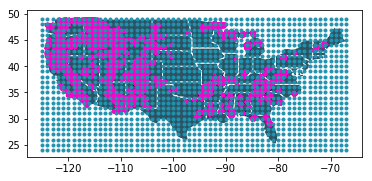

In [31]:
# plot of states
base_map = states.plot(color = '#2c5364', edgecolor = '#ffffff')
# fire points
fires_w_grid.plot(ax=base_map, marker = 'o', color = '#ff00cc', markersize =5)
# coords
plt.plot(glons, glats, marker='.', color='#2193b0', linestyle='none')
plt.show()

In [47]:
# grid points in polygon.
# flatten
grid_id_flat = grid_id_array.flatten()
grid_id = pd.DataFrame(grid_id_flat).astype('str')
grid_id.columns = ['grid_id'] 
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['glon', 'glat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()

,grid_id,glon,glat
0,1,-125.0,24.0
1,2,-124.0,24.0
2,3,-123.0,24.0
3,4,-122.0,24.0
4,5,-121.0,24.0


In [69]:
# grid id in state polygon; convert to geodataframe
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(grid_df.glon, grid_df.glat)]
crs = {'init': 'epsg:4269'}
grid_gdf = gp.GeoDataFrame(grid_df, crs=crs, geometry=geometry)

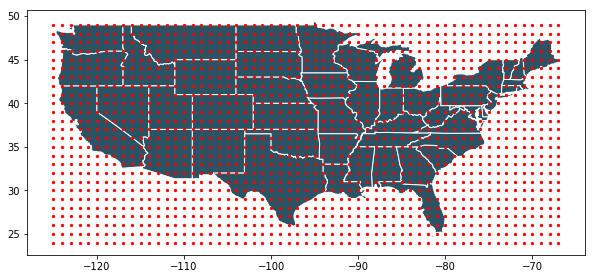

In [70]:
# plot points
base_map = states.plot(color = '#2c5364', edgecolor = '#ffffff')
grid_gdf.plot(ax=base_map, marker = 'o', color = 'red', markersize=5)

In [71]:
print(states.crs, grid_gdf.crs)

{'init': 'epsg:4269'} {'init': 'epsg:4269'}


In [86]:
# spatial join grid points to states
grid_points_state = gp.tools.sjoin(grid_gdf, states, how = 'left')
# keep only grid id, glon, and glat, and state name
grid_state = pd.DataFrame(grid_points_state[['grid_id', 'glon', 'glat', 'NAME']])

In [95]:
# rename
grid_state.rename(columns = {'NAME':'state'}, inplace=True)

In [97]:
# names
grid_state['state'].unique()

array([nan, 'Florida', 'Texas', 'Louisiana', 'Mississippi', 'Alabama',
       'Georgia', 'Arizona', 'New Mexico', 'California', 'South Carolina',
       'Oklahoma', 'Arkansas', 'North Carolina', 'Tennessee', 'Nevada',
       'Missouri', 'Utah', 'Colorado', 'Kansas', 'Kentucky', 'Virginia',
       'Illinois', 'Indiana', 'West Virginia', 'Maryland', 'Ohio',
       'Pennsylvania', 'New Jersey', 'Wyoming', 'Nebraska', 'Iowa',
       'New York', 'Oregon', 'Idaho', 'Michigan', 'Connecticut',
       'Massachusetts', 'South Dakota', 'Wisconsin', 'Vermont',
       'New Hampshire', 'Minnesota', 'Maine', 'Montana', 'Washington',
       'North Dakota'], dtype=object)

In [98]:
# write state grid id
grid_state.to_csv('../data/model_data/grid_state.csv')

### Colorado

Checking Colorado.

In [32]:
# checking colorado fires match up with shape and grid ids
co_fires = fires_w_grid[fires_w_grid['STATE'] == 'Colorado']
# colorado shape
colorado = states[states['STUSPS'] == 'CO']

In [33]:
# bounding box of colorado
co_bbox = colorado.bounds
co_bbox

,minx,miny,maxx,maxy
2,-109.060062,36.992426,-102.041876,41.003073


In [34]:
# lat and lon bounds
latbounds = [36.0, 42.0]
lonbounds = [-109.1, -102.04]

# latitude lower and upper bounds, i had to modify slightly since 
# it was giving the index of the cell
lat_li = np.min(np.argmin(np.abs(glats - latbounds[0]), axis = 0))
lat_ui = np.min(np.argmin(np.abs(glats - latbounds[1]), axis = 0))

# longitude lower and upper boudns
lon_li = np.argmin(np.abs(glons - lonbounds[0]))
lon_ui = np.argmin(np.abs(glons - lonbounds[1]))
# print index
print(lat_li, lat_ui, lon_li, lon_ui)

12 18 16 23


In [35]:
# subset us lon
lon_co = glons[lat_li:lat_ui, lon_li:lon_ui]
# subset us lat
lat_co = glats[lat_li:lat_ui, lon_li:lon_ui]
# subset grid id
grid_co = grid_id_array[lat_li:lat_ui, lon_li:lon_ui]
# print dimensions
print(np.min(lon_co), np.max(lon_co), np.min(lat_co), np.max(lat_co))

-109.0 -103.0 36.0 41.0


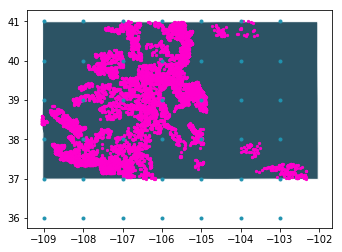

In [36]:
# plot of states
co_map = colorado.plot(color = '#2c5364', edgecolor = '#ffffff')
# fire points
co_fires.plot(ax=co_map, marker = 'o', color = '#ff00cc', markersize =5)
# coords
plt.plot(lon_co, lat_co, marker='.', color='#2193b0', linestyle='none')
plt.show()

In [37]:
grid_co

array([[ 725,  726,  727,  728,  729,  730,  731],
       [ 784,  785,  786,  787,  788,  789,  790],
       [ 843,  844,  845,  846,  847,  848,  849],
       [ 902,  903,  904,  905,  906,  907,  908],
       [ 961,  962,  963,  964,  965,  966,  967],
       [1020, 1021, 1022, 1023, 1024, 1025, 1026]])

In [38]:
# view grid range
print(np.min(grid_co), np.max(grid_co))

725 1026


In [39]:
# view fire range
print(co_fires.grid_id.max(), co_fires.grid_id.min())

965 1022


In [40]:
# denver; should be none
co_spr_fires = co_fires[co_fires['grid_id'] == '906']

In [41]:
co_spr_fires.head()

,ORGANIZATI,UNIT,SUBUNIT,SUBUNIT2,FIREID,FIRENAME,FIRENUMBER,FIRECODE,CAUSE,SPECCAUSE,...,Cat_Field,DuplicateF,FireName_A,Keep,Duplicate_,geometry,lat,lon,grid_id,date
114,FS,02,0212,Pike and San Isabel National Forests,6771504,950,106,KRE4,Human,9,...,KRE4/2016/Colorado/950,None,950,None,0,POINT (-105.0113888898853 38.97944444010886),38.979444,-105.011389,906,2016-09-01
115,FS,02,0212,Pike and San Isabel National Forests,6771511,ICE CAVE,115,KR57,Human,30,...,KR57/2016/Colorado/ICE CAVE,None,ICE CAVE,None,0,POINT (-105.0213888896855 39.10499999965032),39.105000,-105.021389,906,2016-10-01
116,FS,02,0212,Pike and San Isabel National Forests,6771530,Talcott,120,KR91,Human,30,...,KR91/2016/Colorado/TALCOTT,None,TALCOTT,None,0,POINT (-105.0013888900852 38.96000000029983),38.960000,-105.001389,906,2016-10-01
117,FS,02,0212,Pike and San Isabel National Forests,6771553,Barr Trail,122,KSN5,Human,30,...,KSN5/2016/Colorado/BARR TRAIL,None,BARR TRAIL,None,0,POINT (-104.98 38.85194444018384),38.851944,-104.980000,906,2016-10-01
118,FS,02,0212,Pike and San Isabel National Forests,6771561,West Creek,123,KSN7,Human,30,...,KSN7/2016/Colorado/WEST CREEK,None,WEST CREEK,None,0,POINT (-105.1286111101146 39.13138889008525),39.131389,-105.128611,906,2016-10-01


### Water Indicator

Wildfires only occur on land, and I have some water (great lakes and oceans) that grids fall on. I want to create an indicator, so I'm using data from Natural Earth.

Link: https://www.naturalearthdata.com/downloads/50m-natural-earth-2/50m-natural-earth-ii-with-shaded-relief/

Note, I may return to this later. It looks like a lot of work where I could just find the states each one is in. It will not capture South East Canada, but that's okay for now. 

In [43]:
land_water = rasterio.open('../data/shapes/NE2_50M_SR_W/NE2_50M_SR_W.tif')

In [45]:
land_water.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10800,
 'height': 5400,
 'count': 3,
 'crs': CRS({'init': 'epsg:4326'}),
 'transform': (-179.99999999999997,
  0.03333333333333,
  0.0,
  90.0,
  0.0,
  -0.03333333333333),
 'affine': Affine(0.03333333333333, 0.0, -179.99999999999997,
        0.0, -0.03333333333333, 90.0)}

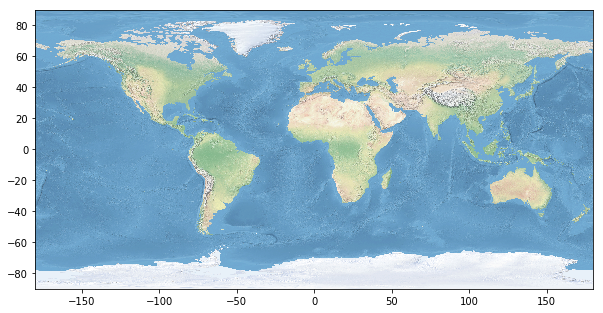

In [44]:
rioplot.show(land_water)

### Save Fire Information with Grid IDs and without Geometry  

Saving as CSV.

In [39]:
# making fires df from geopandas df
fires_info_df = pd.DataFrame(fires_w_grid)

In [41]:
print(fires_info_df.date.min(),fires_info_df.date.max())

1979-12-01 00:00:00 2016-12-01 00:00:00


In [ ]:
# save
#fires_info_df.to_csv('../data/model_data/1979-2016_wildfire_info_us.csv')

### Save Fire Indicator and Counts by Grid ID and Month

I want to group by date and grid id and count up any fires, and fire class type. I can use it later to make an indicator variable.

In [42]:
fires_count = (fires_info_df[['SIZECLASS', 'date', 'grid_id']]
               .groupby(['grid_id', 'date', 'SIZECLASS']).size()
               .unstack().reset_index().fillna(0))

In [43]:
# create an any fire variable
fires_count['fire'] = np.where(((fires_count['A'] > 0) | (fires_count['B'] > 0) |
                              (fires_count['C'] > 0) | (fires_count['D']) |
                              (fires_count['E'] > 0) | (fires_count['F'] > 0) |
                              (fires_count['G'] > 0)), 1, 0)

In [44]:
# fire lat lons
fire_lat_lon = fires_info_df[['grid_id', 'lat', 'lon']]
# join to fire counts
fires_grid_id = fires_count.merge(fire_lat_lon, left_on='grid_id', 
                                right_on='grid_id', how='left')

In [45]:
# check; looks good
fires_count.head()

SIZECLASS,grid_id,date,A,B,C,D,E,F,G,fire
0,1005,1980-05-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,1005,1980-06-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1005,1980-07-01,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,1005,1980-08-01,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,1005,1980-09-01,4.0,3.0,0.0,0.0,0.0,0.0,0.0,1


In [46]:
fires_count.tail()

SIZECLASS,grid_id,date,A,B,C,D,E,F,G,fire
52621,989,2001-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
52622,989,2001-11-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
52623,989,2006-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
52624,989,2013-11-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
52625,989,2015-03-01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1


In [47]:
# check shape
fires_count.shape

(52626, 10)

In [48]:
# write fires
#fires_count.to_csv('../data/model_data/1979-2016_wildfire_grid.csv')

### Descriptives of Fires

Counts of fire types.

In [ ]:
# summarise number of fires; needs reset index
fire_counts = (fires_w_grid[['SIZECLASS', 'TOTALACRES', 'FiscalYear']]
               .groupby(['FiscalYear', 'SIZECLASS']).count().reset_index())

# convert size class to category
fire_counts['SIZECLASS'] = fire_counts['SIZECLASS'].astype('category')

In [ ]:
# view first couple
fire_counts.head()

In [ ]:
fire_counts.dtypes

In [ ]:
# number of fires by year over time
sns.lmplot(x='FiscalYear', y='TOTALACRES', hue = 'SIZECLASS', fit_reg = False, data = fire_counts)

In [ ]:
# avg acres burned 
fire_acres = (fires_w_grid[['TOTALACRES', 'FiscalYear']]
               .groupby(['FiscalYear']).mean().reset_index())

# convert size class to category
fire_acres.head()

In [ ]:
# number of fires by year over time
ax = sns.lmplot(x='FiscalYear', y='TOTALACRES', data = fire_acres)
ax.set(xlabel = 'Year', ylabel = 'Average Acres Burned')